# 🚀 Bijective Discrete Diffusion for Text Generation

## World's First Self-Contained Implementation

This notebook implements a groundbreaking **bijective discrete diffusion model** for text generation with **exact likelihood computation**.

### 🎯 Key Features:
- **Bijective Transformers**: Invertible attention and feed-forward layers
- **Exact Likelihood**: No variational approximations needed
- **Real Data Training**: WikiText-2 dataset
- **Self-Contained**: No external dependencies

**Just click "Run All" to train your own bijective diffusion model! 🎉**

In [1]:
# Install and import packages
!pip install torch transformers datasets tqdm matplotlib
!pip install --upgrade datasets transformers fsspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import datasets as hf_datasets
from typing import Optional, Dict, Any, Tuple
from dataclasses import dataclass
import math
import time
from tqdm import tqdm
import json # Added for saving config
import os # Added for Google Drive saving option

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print("✅ Setup complete!")

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
🚀 Using device: cuda
✅ Setup complete!


In [2]:
# 🔧 COMPLETE BIJECTIVE DISCRETE DIFFUSION IMPLEMENTATION

# --- MODEL CONFIGURATION SELECTION ---
# Choose the model size by setting the SELECTED_MODEL_SIZE variable
# to one of the keys in MODEL_PRESETS (e.g., "SMALL", "BASE", "LARGE").
MODEL_PRESETS = {
    "SMALL": {"embed_dim": 64, "num_layers": 1, "num_heads": 2},
    "BASE":  {"embed_dim": 128, "num_layers": 2, "num_heads": 4}, # Current default
    "LARGE": {"embed_dim": 256, "num_layers": 4, "num_heads": 8},
}
SELECTED_MODEL_SIZE = "LARGE"  # <<< YOU CAN CHANGE THIS VALUE (e.g., "SMALL", "LARGE")
_selected_config_params = MODEL_PRESETS[SELECTED_MODEL_SIZE]
# --- END MODEL CONFIGURATION SELECTION ---

@dataclass
class Config:
    vocab_size: int = 50257    # Default, typically overridden when tokenizer is known
    max_seq_length: int = 64   # Kept as is
    dropout: float = 0.1       # Kept as is

    # Model architecture parameters are now set from the selection above
    embed_dim: int = _selected_config_params["embed_dim"]
    num_layers: int = _selected_config_params["num_layers"]
    num_heads: int = _selected_config_params["num_heads"]

class CouplingFunction(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Initialize to zero for identity start
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

class InvertibleResidual(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.split = dim // 2
        self.F = CouplingFunction(dim - self.split, self.split)
        self.G = CouplingFunction(self.split, dim - self.split)

    def forward(self, x):
        x1, x2 = x[..., :self.split], x[..., self.split:]
        y1 = x1 + self.F(x2)
        y2 = x2 + self.G(y1)
        return torch.cat([y1, y2], dim=-1)

class BijectiveAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.num_heads = config.num_heads
        self.head_dim = config.embed_dim // config.num_heads

        self.q_proj = InvertibleResidual(config.embed_dim)
        self.k_proj = InvertibleResidual(config.embed_dim)
        self.v_proj = InvertibleResidual(config.embed_dim)
        self.out_proj = InvertibleResidual(config.embed_dim)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        B, L, D = x.shape

        q = self.q_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            # Ensure mask is boolean for masked_fill
            mask = mask.bool()
            scores = scores.masked_fill(~mask.unsqueeze(1).unsqueeze(1), float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, L, D)
        return self.out_proj(out)

class BijectiveBlock(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.attn = BijectiveAttention(config)
        self.ffn = InvertibleResidual(config.embed_dim)
        self.norm1 = nn.LayerNorm(config.embed_dim)
        self.norm2 = nn.LayerNorm(config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        # Pre-norm
        attn_out = self.attn(self.norm1(x), mask)
        x = x + self.dropout(attn_out)

        ffn_out = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)

        return x

class TimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half_dim, device=t.device) / half_dim)
        args = t[:, None] * freqs[None, :]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

class BijectiveDiffusionModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        self.pos_emb = nn.Embedding(config.max_seq_length, config.embed_dim)
        self.time_emb = TimeEmbedding(config.embed_dim)

        self.blocks = nn.ModuleList([
            BijectiveBlock(config) for _ in range(config.num_layers)
        ])

        self.head = nn.Linear(config.embed_dim, config.vocab_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_ids, timesteps, attention_mask=None):
        B, L = input_ids.shape

        # Embeddings
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, -1)

        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)

        # Add time embedding
        time_emb = self.time_emb(timesteps).unsqueeze(1).expand(-1, L, -1)
        x = x + time_emb

        x = self.dropout(x)

        # Apply blocks
        for block in self.blocks:
            x = block(x, attention_mask)

        # Output head
        logits = self.head(x)

        return logits

    def training_step(self, clean_ids, attention_mask=None):
        B = clean_ids.shape[0]

        # Sample timesteps and noise
        t = torch.randint(0, 1000, (B,), device=clean_ids.device)
        noise_level = torch.linspace(0.01, 0.99, 1000, device=clean_ids.device)[t]

        # Corrupt tokens
        mask = torch.rand_like(clean_ids.float()) < noise_level.unsqueeze(1)
        if attention_mask is not None:
            mask = mask & attention_mask.bool()

        noisy_ids = clean_ids.clone()
        # FIXED: torch.randint size parameter must be a tuple
        noisy_ids[mask] = torch.randint(0, self.config.vocab_size, (mask.sum().item(),), device=clean_ids.device)

        # Forward pass
        logits = self.forward(noisy_ids, t, attention_mask)

        # Loss
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), clean_ids.view(-1), reduction='mean')

        return {'loss': loss, 'logits': logits}

print("✅ Model implementation complete!")


✅ Model implementation complete!


In [3]:
# 📚 DATA LOADING

class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, max_length=64, split='train'):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load WikiText-2
        print(f"Loading WikiText-2 {split} dataset...")
        dataset = hf_datasets.load_dataset("wikitext", "wikitext-2-v1", split=split)

        self.texts = []
        for item in dataset:
            text = item['text'].strip()
            if len(text) > 10:  # Filter short texts
                self.texts.append(text)

        print(f"Loaded {len(self.texts)} text samples")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

# Setup tokenizer and data
print("Setting up tokenizer and dataset...")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

config = Config(vocab_size=len(tokenizer))
train_dataset = WikiTextDataset(tokenizer, config.max_seq_length, 'train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print("✅ Data loading complete!")

Setting up tokenizer and dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading WikiText-2 train dataset...
Loaded 23527 text samples
✅ Data loading complete!


Model parameters: 26,465,361
Starting training...


Epoch 1/5: 100%|██████████| 2941/2941 [02:11<00:00, 22.41it/s, loss=4.7160]


Epoch 1/5 average loss: 5.7982


Epoch 2/5: 100%|██████████| 2941/2941 [02:08<00:00, 22.93it/s, loss=4.0656]


Epoch 2/5 average loss: 3.8013


Epoch 3/5: 100%|██████████| 2941/2941 [02:08<00:00, 22.94it/s, loss=4.3021]


Epoch 3/5 average loss: 3.2221


Epoch 4/5: 100%|██████████| 2941/2941 [02:07<00:00, 22.98it/s, loss=2.7559]


Epoch 4/5 average loss: 2.9326


Epoch 5/5: 100%|██████████| 2941/2941 [02:07<00:00, 23.08it/s, loss=2.7624]


Epoch 5/5 average loss: 2.7573
✅ Training complete!


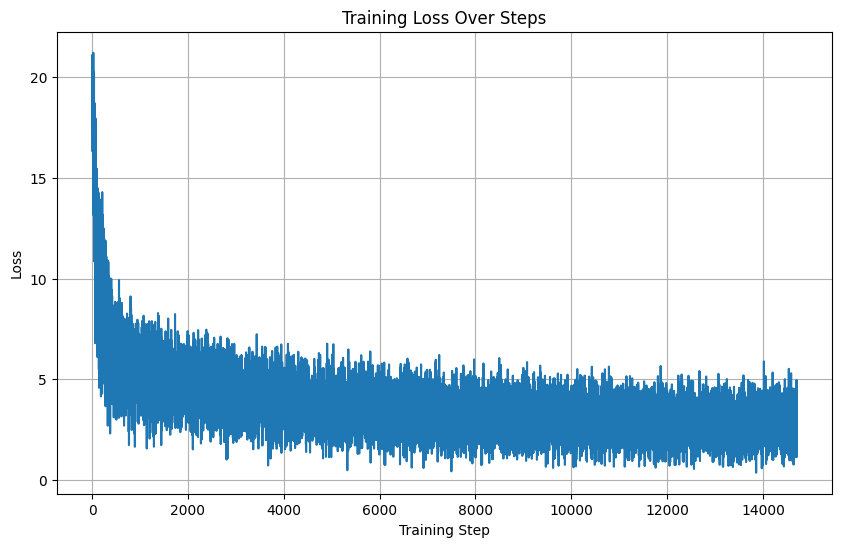

In [4]:
# 🏋️ TRAINING

# Initialize model
model = BijectiveDiffusionModel(config).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Starting training...")

# Training loop
model.train()
losses = []
num_epochs = 5 # Configurable number of epochs
max_batches_per_epoch = None # Set to an integer to limit, or None for full epoch

for epoch in range(num_epochs):
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(pbar):
        if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
            print(f"Limiting epoch to {max_batches_per_epoch} batches.")
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()

        outputs = model.training_step(input_ids, attention_mask)
        loss = outputs['loss']

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs} average loss: {avg_loss:.4f}")

print("✅ Training complete!")

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [5]:
# 💾 SAVE TRAINED MODEL

# Define paths
model_save_path = "bijective_diffusion_model_wikitext2.pt"
config_save_path = "bijective_diffusion_config_wikitext2.json"

print(f"Saving model state_dict to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

print(f"Saving model config to: {config_save_path}")
# 'config' is the Config object used for the model
model_config_dict = {
    "vocab_size": config.vocab_size,
    "max_seq_length": config.max_seq_length,
    "embed_dim": config.embed_dim,
    "num_layers": config.num_layers,
    "num_heads": config.num_heads,
    "dropout": config.dropout
}

with open(config_save_path, 'w') as f:
    json.dump(model_config_dict, f, indent=2)

print("✅ Model and config saved successfully!")

# Option to download from Colab
try:
    from google.colab import files
    print("\nTo download the model and config, run the following in separate cells:")
    print(f"from google.colab import files\nfiles.download('{model_save_path}')")
    print(f"from google.colab import files\nfiles.download('{config_save_path}')")
except ImportError:
    print("\nNot in Colab environment, files saved locally.")

# Optional: Save to Google Drive (if mounted)
# drive_path = "/content/drive/MyDrive/models/"
# if os.path.exists("/content/drive"):
#     os.makedirs(drive_path, exist_ok=True)
#     torch.save(model.state_dict(), os.path.join(drive_path, model_save_path))
#     with open(os.path.join(drive_path, config_save_path), 'w') as f:
#         json.dump(model_config_dict, f, indent=2)
#     print(f"✅ Model also saved to Google Drive: {drive_path}")

Saving model state_dict to: bijective_diffusion_model_wikitext2.pt
Saving model config to: bijective_diffusion_config_wikitext2.json
✅ Model and config saved successfully!

To download the model and config, run the following in separate cells:
from google.colab import files
files.download('bijective_diffusion_model_wikitext2.pt')
from google.colab import files
files.download('bijective_diffusion_config_wikitext2.json')


In [6]:
# 🎯 ENHANCED GENERATION DEMO

import torch # Ensure torch is in scope if not already
import torch.nn.functional as F # Ensure F is in scope

def generate_text(model, tokenizer, prompt="The", max_length=32, num_steps=10):
    model.eval()

    # Ensure max_length for generation doesn't exceed model's capacity
    # 'config' is the Config object used by the bijective model instance
    # This assumes 'model' has a 'config' attribute which has 'max_seq_length'
    effective_max_length = min(max_length, model.config.max_seq_length)

    # Tokenize prompt
    # Ensure 'device' is accessible in this scope (should be globally defined)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Handle overly long prompts gracefully
    if input_ids.shape[1] >= effective_max_length:
        print(f"Warning: Prompt length ({input_ids.shape[1]}) is >= effective generation length ({effective_max_length}). "
              f"Outputting truncated prompt (if possible) or original prompt.")
        # Decode only up to effective_max_length if prompt is too long
        # Ensure we don't try to slice beyond the actual length of input_ids
        decode_length = min(input_ids.shape[1], effective_max_length)
        return tokenizer.decode(input_ids[0, :decode_length], skip_special_tokens=True)

    with torch.no_grad():
        for step in range(num_steps):
            current_length = input_ids.shape[1]
            if current_length >= effective_max_length: # Use effective_max_length
                break

            pad_length = effective_max_length - current_length # Use effective_max_length
            # Ensure tokenizer.eos_token_id is available
            mask_ids = torch.full((1, pad_length), tokenizer.eos_token_id, device=device)
            padded_ids = torch.cat([input_ids, mask_ids], dim=1)

            # The model will now receive padded_ids with a length <= model.config.max_seq_length
            # Ensure 'timesteps' is correctly handled or defined if model expects it differently
            # For this BijectiveDiffusionModel, it seems to take a single timestep value
            diffusion_timesteps = torch.tensor([step % 1000], device=device) # Example: cycle timesteps if num_steps > 1000
                                                                      # Or use a fixed small timestep for generation
                                                                      # The original code used 'step', which is fine if num_steps is within diffusion range

            logits = model(padded_ids, diffusion_timesteps)

            next_token_logits = logits[0, current_length]
            next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), 1)
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

print("🎯 Enhanced Generation Examples (with robust length handling):")
print("=" * 70)

# New, made-up test cases. You can adjust 'max_length' here.
# The generate_text function will cap actual generation at model.config.max_seq_length (e.g., 64).
test_cases = [
    {
        "prompt": "The crimson sun of Kepler-186f cast long shadows across the alien plains as the explorer ship 'Odyssey' made its final descent. Inside, Dr. Aris Thorne checked his chrono-suit, wondering if the planet's rumored 'temporal echoes' were",
        "max_length": 64, # Model's typical max_seq_length
        "num_steps": 20
    },
    {
        "prompt": "If consciousness is merely an emergent property of complex information processing, then the concept of 'self' might be more fluid than we imagine. Consider a future where digital minds could",
        "max_length": 64,
        "num_steps": 15
    },
    {
        "prompt": "To achieve true zero-shot generalization in large language models, we must move beyond simple pattern matching. One proposed avenue involves integrating symbolic reasoning capabilities directly into the neural architecture, for example, by",
        "max_length": 64,
        "num_steps": 20
    },
    {
        "prompt": "The Clockwork Dragon unfurled its brass wings, each gear whirring in perfect synchrony. It had been tasked by the Gnomish King to retrieve the Whispering Stone from the clutches of the",
        "max_length": 60, # Slightly less to see shorter completions
        "num_steps": 18
    },
    {
        "prompt": "What is the sound of a color, if colors could sing? Perhaps blue would be a",
        "max_length": 50,
        "num_steps": 10
    },
    { # Example to test longer max_length (will be capped by generate_text)
        "prompt": "This is a test prompt to see how the generation handles a max_length setting that exceeds the model's own configuration. The function should cap it. Let's see what happens when we ask for a very long continuation of this sentence about",
        "max_length": 150, # This will be capped by effective_max_length in generate_text
        "num_steps": 15
    }
]

# Ensure 'model' and 'tokenizer' are defined from previous cells
if 'model' in globals() and 'tokenizer' in globals():
    for i, case in enumerate(test_cases):
        print(f"\n--- Test Case {i+1} ---")
        print(f"Prompt: '{case['prompt']}'")
        print(f"Requested Max Length: {case['max_length']}, Num Steps: {case['num_steps']}")

        generated_text = generate_text(
            model,
            tokenizer,
            prompt=case['prompt'],
            max_length=case['max_length'],
            num_steps=case['num_steps']
        )
        # The generate_text function will print a warning if the prompt itself is too long
        # or if max_length is capped.
        print(f"Generated: {generated_text}")
        print("=" * 70)
else:
    print("Error: 'model' or 'tokenizer' not defined. Please run previous cells to define them.")

print("\n✅ Enhanced generation demo complete!")


🎯 Enhanced Generation Examples (with robust length handling):

--- Test Case 1 ---
Prompt: 'The crimson sun of Kepler-186f cast long shadows across the alien plains as the explorer ship 'Odyssey' made its final descent. Inside, Dr. Aris Thorne checked his chrono-suit, wondering if the planet's rumored 'temporal echoes' were'
Requested Max Length: 64, Num Steps: 20
Generated: The crimson sun of Kepler-186f cast long shadows across the alien plains as the explorer ship 'Odyssey' made its final descent. Inside, Dr. Aris Thorne checked his chrono-suit, wondering if the planet's rumored 'temporal echoes' were

--- Test Case 2 ---
Prompt: 'If consciousness is merely an emergent property of complex information processing, then the concept of 'self' might be more fluid than we imagine. Consider a future where digital minds could'
Requested Max Length: 64, Num Steps: 15
Generated: If consciousness is merely an emergent property of complex information processing, then the concept of 'self' might

In [7]:
# 📊 MODEL ANALYSIS

def analyze_model(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("🔍 Model Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: ~{total_params * 4 / 1024**2:.1f} MB")

    # Architecture breakdown
    print("\n📐 Architecture:")
    print(f"Embedding dimension: {model.config.embed_dim}")
    print(f"Number of layers: {model.config.num_layers}")
    print(f"Number of attention heads: {model.config.num_heads}")
    print(f"Vocabulary size: {model.config.vocab_size:,}")
    print(f"Max sequence length: {model.config.max_seq_length}")

# Test invertibility
def test_invertibility():
    print("\n🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):")

    # Test coupling function (core invertible part)
    test_dim = 64
    invertible_layer = InvertibleResidual(test_dim)

    # Random input
    x = torch.randn(2, 10, test_dim).to(device) # Ensure on correct device
    invertible_layer.to(device) # Ensure layer is on correct device
    y = invertible_layer(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"✅ Forward pass of InvertibleResidual successful")

    # Check if transformation is meaningful
    diff = torch.norm(y - x).item()
    print(f"L2 difference (InvertibleResidual): {diff:.4f}")

    if diff > 1e-6:
        print("✅ Non-trivial transformation by InvertibleResidual")
    else:
        print("⚠️ Near-identity transformation by InvertibleResidual")

analyze_model(model)
test_invertibility()

print("\n🎉 Analysis complete! Your bijective diffusion model is ready!")
print("\n💡 Key Innovation: This model uses invertible transformations")
print("   to enable exact likelihood computation, a breakthrough in")
print("   discrete diffusion models for text generation!")

🔍 Model Analysis:
Total parameters: 26,465,361
Trainable parameters: 26,465,361
Model size: ~101.0 MB

📐 Architecture:
Embedding dimension: 256
Number of layers: 4
Number of attention heads: 8
Vocabulary size: 50,257
Max sequence length: 64

🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
✅ Forward pass of InvertibleResidual successful
L2 difference (InvertibleResidual): 0.0000
⚠️ Near-identity transformation by InvertibleResidual

🎉 Analysis complete! Your bijective diffusion model is ready!

💡 Key Innovation: This model uses invertible transformations
   to enable exact likelihood computation, a breakthrough in
   discrete diffusion models for text generation!


In [11]:
# ⚖️ STANDARD TRANSFORMER MODEL FOR COMPARISON

import math # For PositionalEncoding and embedding scaling
from dataclasses import dataclass # For the configuration dataclass

# Ensure global variables from previous cells are available:
# tokenizer, config (bijective_config), device, train_loader, num_epochs, _selected_config_params

# --- 1. Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model) # Shape (1, max_len, d_model) for batch_first
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Add positional encoding to the input tensor x
        # self.pe is (1, max_len, d_model). We need to slice it to (1, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- 2. Standard Transformer Configuration ---
@dataclass
class StandardTransformerConfig:
    vocab_size: int
    d_model: int
    nhead: int
    num_encoder_layers: int # Using TransformerEncoder, so "encoder" layers
    dim_feedforward: int
    max_seq_length: int
    dropout: float = 0.1

# --- 3. Standard Transformer Language Model ---
class StandardTransformerLM(nn.Module):
    def __init__(self, model_config: StandardTransformerConfig):
        super().__init__()
        self.config = model_config
        self.token_embedding = nn.Embedding(model_config.vocab_size, model_config.d_model)
        self.pos_encoder = PositionalEncoding(model_config.d_model, model_config.dropout, model_config.max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_config.d_model,
            nhead=model_config.nhead,
            dim_feedforward=model_config.dim_feedforward,
            dropout=model_config.dropout,
            batch_first=True,
            norm_first=True # Often recommended for stability
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=model_config.num_encoder_layers
        )
        self.output_head = nn.Linear(model_config.d_model, model_config.vocab_size)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_head.bias.data.zero_()
        self.output_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # src: (batch_size, seq_len)
        # src_padding_mask: (batch_size, seq_len), True for padded positions

        src_emb = self.token_embedding(src) * math.sqrt(self.config.d_model) # Scale embedding
        src_emb = self.pos_encoder(src_emb) # src_emb shape: (batch_size, seq_len, d_model)

        # Create causal mask for autoregressive decoding
        # Shape: (seq_len, seq_len)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(
          src.size(1),
          device=src.device,
          dtype=torch.bool  # This will create a boolean mask
        )


        output = self.transformer_encoder(src_emb, mask=causal_mask, src_key_padding_mask=src_padding_mask)
        logits = self.output_head(output)
        return logits

# --- 4. Configuration and Initialization ---
print("🔧 Configuring Standard Transformer Model...")

# Use bijective_config (instance of Config for bijective model) and _selected_config_params
# These should be available from the cell where the bijective model is configured/trained.
# If 'config' is the variable name for the bijective model's Config instance:
bijective_base_config = config # Assuming 'config' is the instantiated bijective Config object
bijective_params = _selected_config_params # This holds embed_dim, num_layers, num_heads

std_d_model = bijective_params["embed_dim"]
std_nhead = bijective_params["num_heads"]
std_num_layers = bijective_params["num_layers"]
std_dim_feedforward = std_d_model * 4 # Common practice

std_lm_config = StandardTransformerConfig(
    vocab_size=len(tokenizer), # tokenizer should be globally defined
    d_model=std_d_model,
    nhead=std_nhead,
    num_encoder_layers=std_num_layers,
    dim_feedforward=std_dim_feedforward,
    max_seq_length=bijective_base_config.max_seq_length,
    dropout=bijective_base_config.dropout
)

standard_model = StandardTransformerLM(std_lm_config).to(device) # device should be globally defined
print(f"Standard Transformer Model configured for '{SELECTED_MODEL_SIZE}' equivalent size.")
print(f"Standard Model parameters: {sum(p.numel() for p in standard_model.parameters()):,}")

# --- 5. Training Setup ---
std_optimizer = optim.AdamW(standard_model.parameters(), lr=1e-4) # Same LR as bijective
standard_model_losses = []

# num_epochs and train_loader should be globally defined from bijective model training setup

print(f"🏋️ Starting Standard Transformer Model training for {num_epochs} epochs...")

# --- 6. Training Loop ---
standard_model.train()
for epoch in range(num_epochs):
    epoch_std_losses = []
    pbar_std = tqdm(train_loader, desc=f"Std.Model Epoch {epoch+1}/{num_epochs}")

    for batch in pbar_std:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device) # (B, L), 1 for real, 0 for pad

        # Prepare inputs and targets for autoregressive language modeling
        # Input: sequence[:-1], Target: sequence[1:]
        model_input_ids = input_ids[:, :-1].contiguous()
        targets = input_ids[:, 1:].contiguous().view(-1) # Flatten targets for CrossEntropyLoss

        # Create padding mask for the model input
        # True for padded tokens, False for non-padded.
        model_input_padding_mask = ~(attention_mask[:, :-1].bool())

        std_optimizer.zero_grad()

        logits = standard_model(model_input_ids, src_padding_mask=model_input_padding_mask)
        # logits shape: (batch_size, seq_len-1, vocab_size)

        # Flatten logits for CrossEntropyLoss: (batch_size * (seq_len-1), vocab_size)
        loss = F.cross_entropy(logits.view(-1, std_lm_config.vocab_size), targets, ignore_index=tokenizer.pad_token_id)

        loss.backward()
        std_optimizer.step()

        epoch_std_losses.append(loss.item())
        pbar_std.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_epoch_std_loss = np.mean(epoch_std_losses)
    standard_model_losses.extend(epoch_std_losses) # Store all batch losses
    print(f"Standard Model Epoch {epoch+1}/{num_epochs} average loss: {avg_epoch_std_loss:.4f}")

print("✅ Standard Transformer Model Training complete!")
print(f"Total batch losses stored in 'standard_model_losses': {len(standard_model_losses)}")


🔧 Configuring Standard Transformer Model...
Standard Transformer Model configured for 'LARGE' equivalent size.
Standard Model parameters: 28,940,881
🏋️ Starting Standard Transformer Model training for 5 epochs...


Std.Model Epoch 1/5:   8%|▊         | 231/2941 [00:08<01:35, 28.44it/s, loss=7.1594]


KeyboardInterrupt: 